## Dimensionality Reduction
As the name says, dimensionality reduction is the idea of reducing your feature set to a much smaller number. Dimensionality reduction is often used in visualization of datasets to try and detect samples that are similar. We will cover three dimensionality reduction techniques here: 
1. t-SNE
2. PCA
3. umap

In [1]:
# Packages we will use throughout this notebook
using UMAP
using Makie
using XLSX
using VegaDatasets
using DataFrames
using MultivariateStats
using RDatasets
using StatsBase
using Statistics
using LinearAlgebra
using Plots
using PyCall
using MLBase
using Distances

In [2]:
default(
    size=(800, 600),
    dpi=300,
)

We will use a dataset from the VegaDatasets package. The dataset is about car specifications of over 400 car models.

In [3]:
C = DataFrame(VegaDatasets.dataset("cars"));

In [4]:
dropmissing!(C)
M = Matrix(C[:,2:7])
names(C)

9-element Vector{String}:
 "Name"
 "Miles_per_Gallon"
 "Cylinders"
 "Displacement"
 "Horsepower"
 "Weight_in_lbs"
 "Acceleration"
 "Year"
 "Origin"

In [5]:
car_origin = C[:,:Origin]
carmap = labelmap(car_origin) #from MLBase
uniqueids = labelencode(carmap,car_origin);

### 1️⃣ PCA 
We will first center the data.

In [6]:
# center and normalize the data
data = M
data = (data .- mean(data,dims = 1))./ std(data,dims=1);

PCA expects each column to be an observation, so we will use the transpose of the matrix.

First, we will fit the model via PCA. `maxoutdim` is the output dimensions, we want it to be 2 in this case.

In [7]:
p = fit(PCA,data',maxoutdim=2)

PCA(indim = 6, outdim = 2, principalratio = 0.9194828785333574)

Pattern matrix (unstandardized loadings):
───────────────────────
         PC1        PC2
───────────────────────
1  -0.873037  -0.20899
2   0.942277   0.126601
3   0.97054    0.092613
4   0.94995   -0.141833
5   0.941156   0.244211
6  -0.638795   0.761967
───────────────────────

Importance of components:
─────────────────────────────────────────────
                                PC1       PC2
─────────────────────────────────────────────
SS Loadings (Eigenvalues)  4.78827   0.728631
Variance explained         0.798044  0.121439
Cumulative variance        0.798044  0.919483
Proportion explained       0.867927  0.132073
Cumulative proportion      0.867927  1.0
─────────────────────────────────────────────

We can obtain the projection matrix by calling the function `projection`

In [8]:
P = projection(p);

Now that we have the projection matrix, `P`, we can apply it on one car as follows:

In [9]:
P'*(data[1,:]-mean(p))

2-element Vector{Float64}:
 -2.3230016965226916
 -0.5713519642644695

Or we can transorm all the data via the transform function.

In [10]:
Yte = MultivariateStats.transform(p, data') #notice that Yte[:,1] is the same as P'*(data[1,:]-mean(p))

2×392 Matrix{Float64}:
 -2.323     -3.20196  -2.66658   -2.60214   …   1.22011  1.70921   1.86951
 -0.571352  -0.68187  -0.992744  -0.621975     -1.87471  0.632857  0.815607

We can also go back from two dimensions to 6 dimensions, via the `reconstruct` function... But this time, it will be approximate.

In [11]:
# reconstruct testing observations (approximately)
Xr = reconstruct(p, Yte);

In [12]:
norm(Xr-data') # this won't be zero

13.743841055569009

Finally, we will generate a scatter plot of the cars:

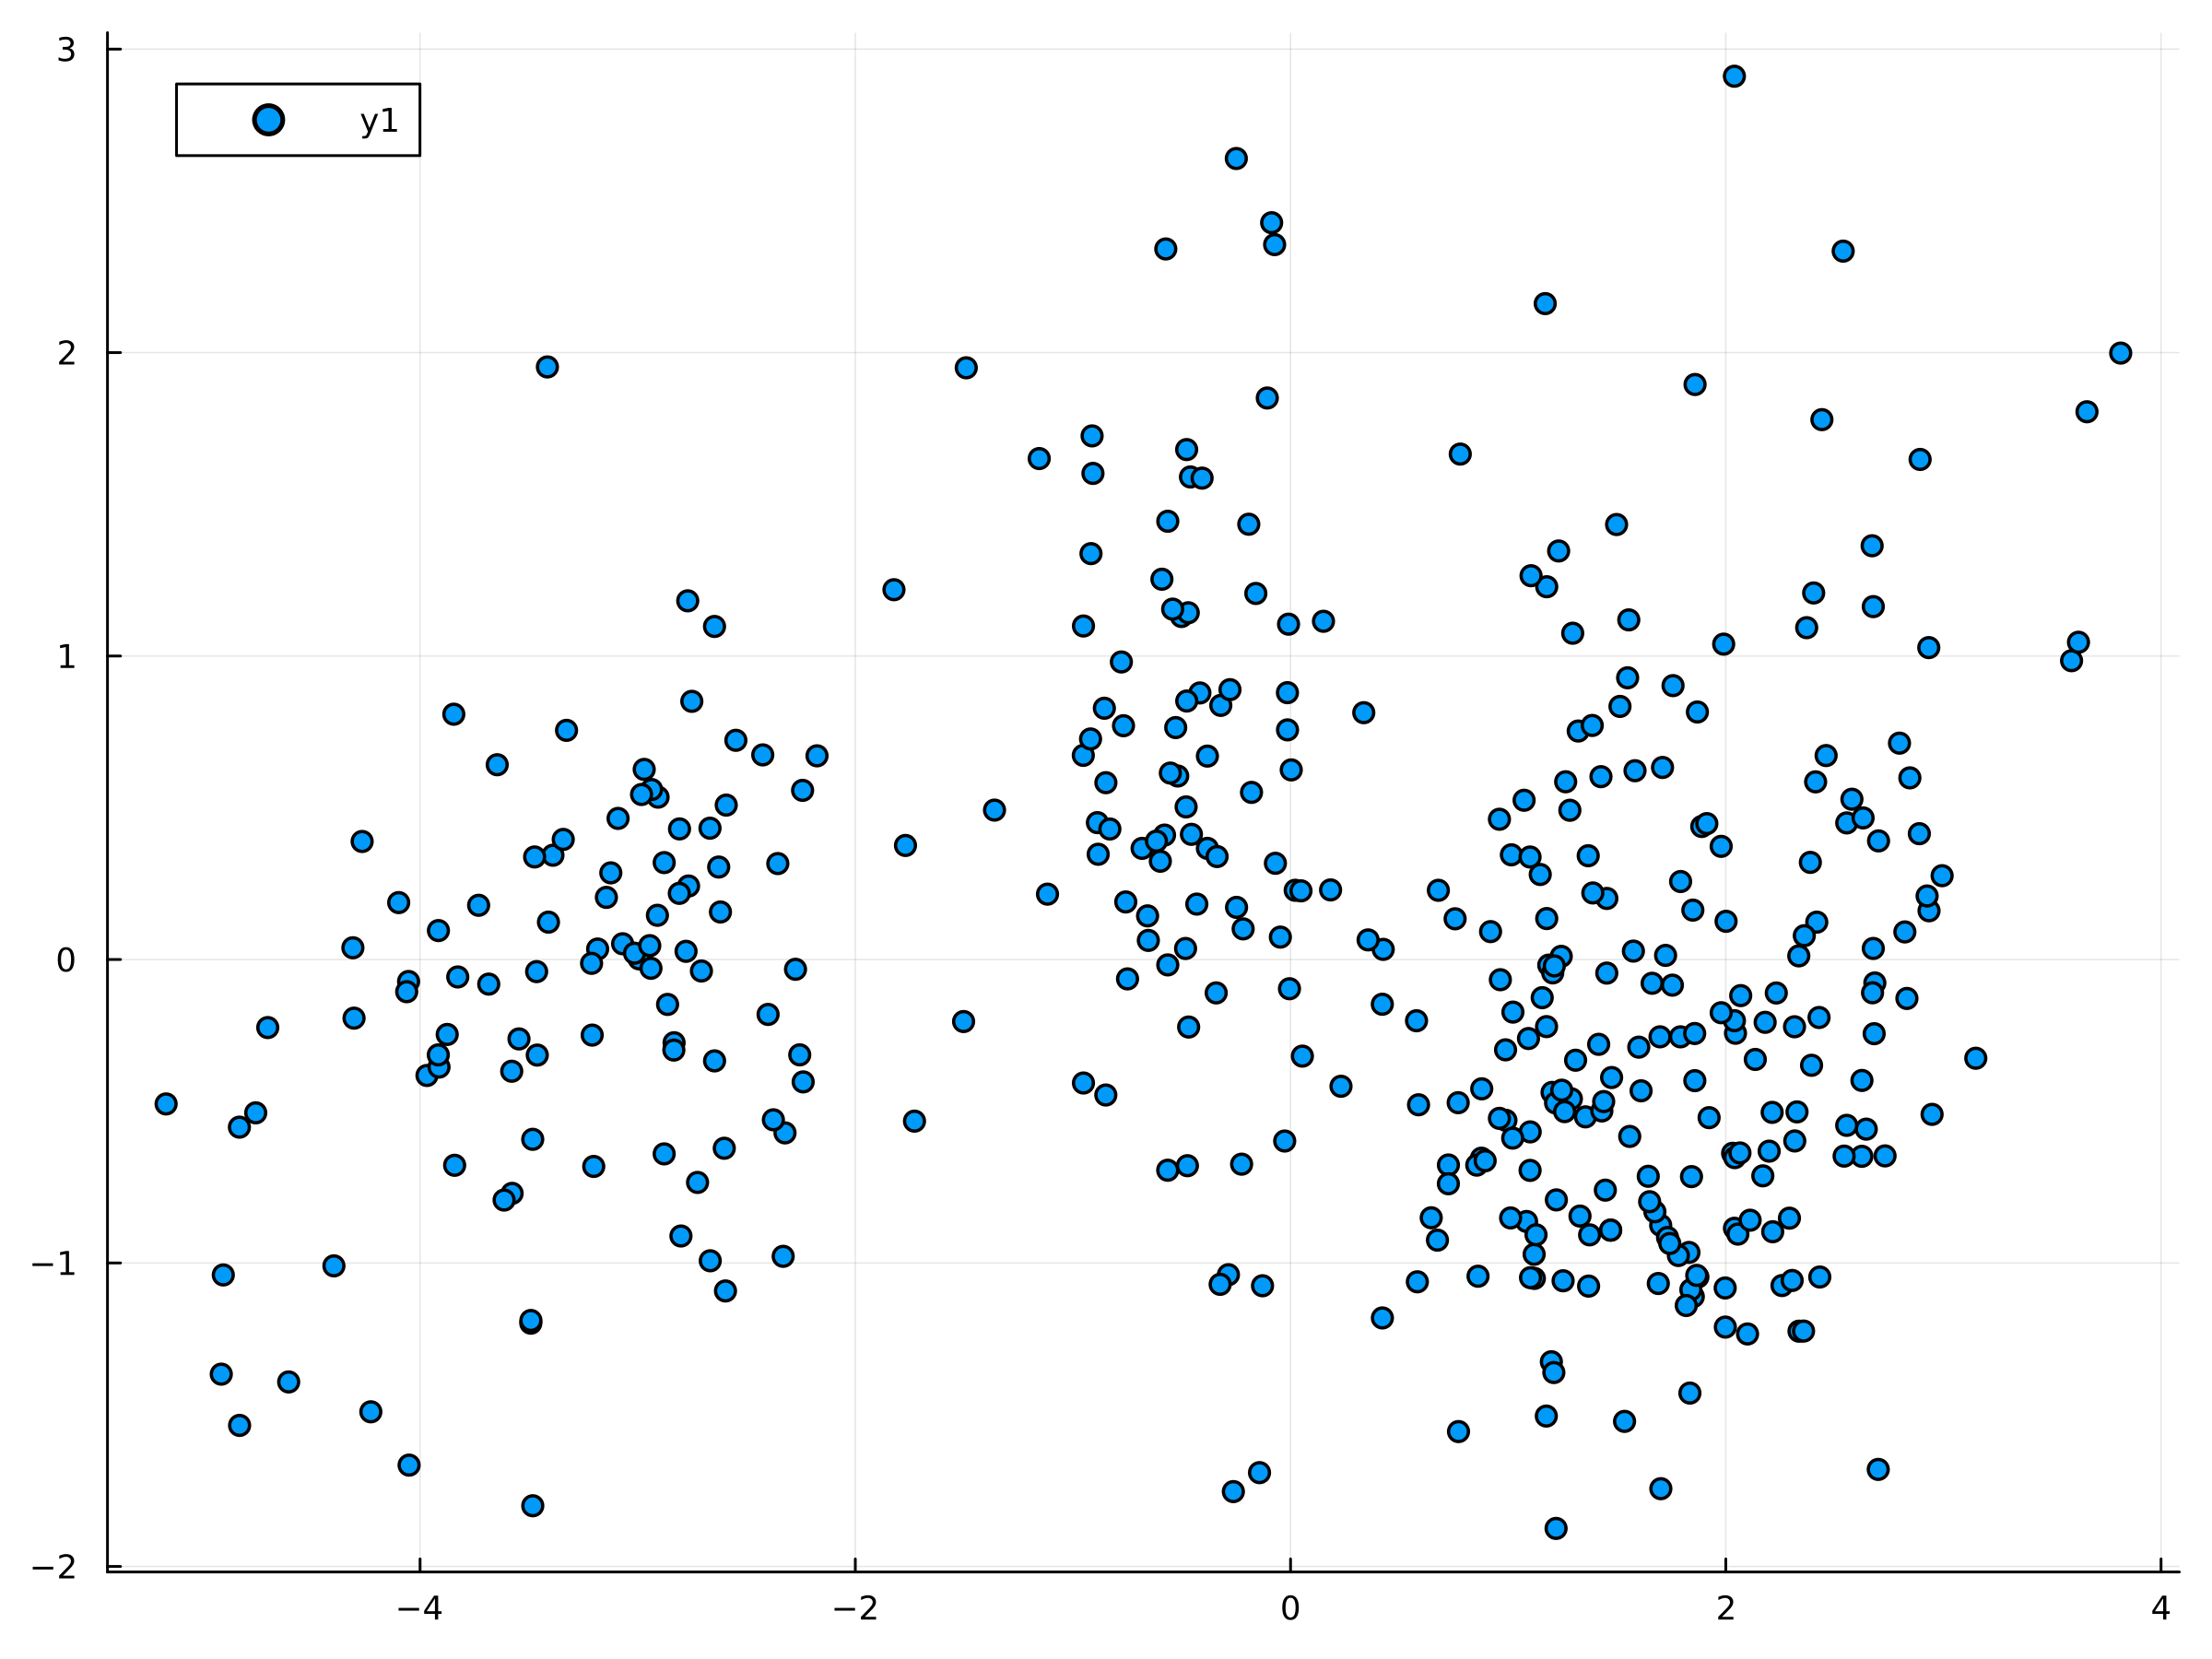

In [13]:
Plots.scatter(Yte[1,:],Yte[2,:])

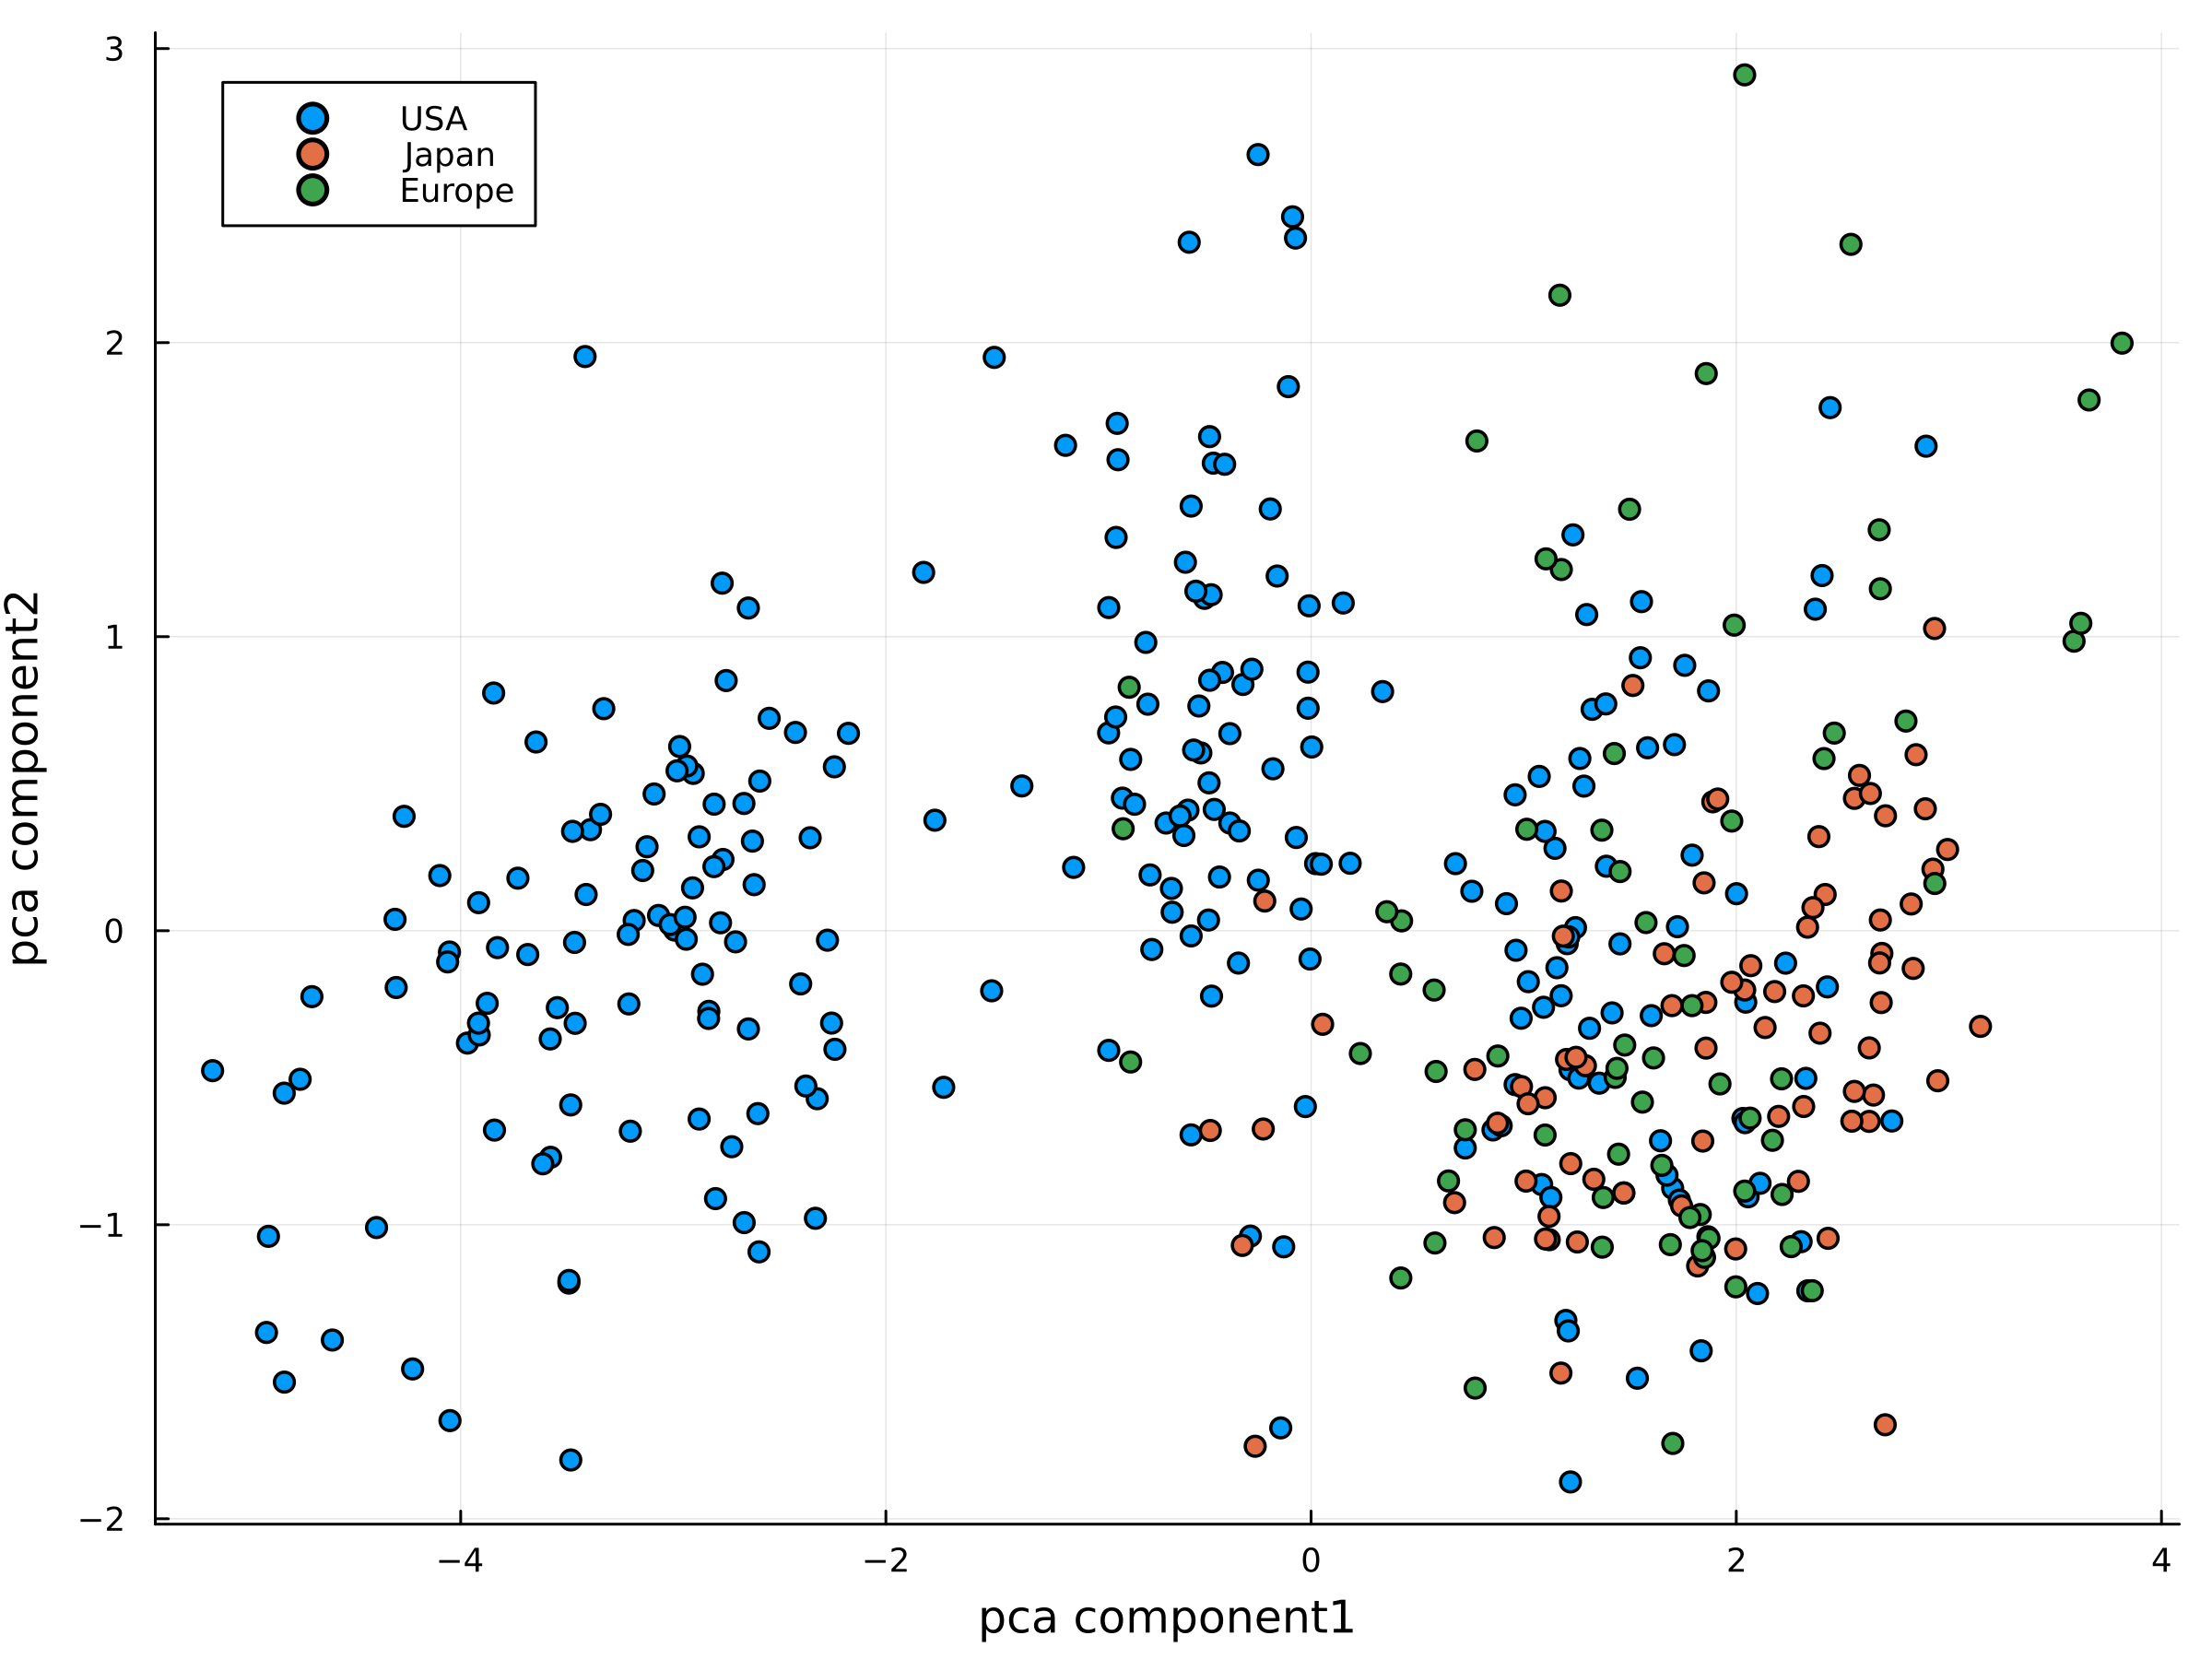

In [14]:
Plots.scatter(Yte[1,car_origin.=="USA"],Yte[2,car_origin.=="USA"],color=1,label="USA")
Plots.xlabel!("pca component1")
Plots.ylabel!("pca component2")
Plots.scatter!(Yte[1,car_origin.=="Japan"],Yte[2,car_origin.=="Japan"],color=2,label="Japan")
Plots.scatter!(Yte[1,car_origin.=="Europe"],Yte[2,car_origin.=="Europe"],color=3,label="Europe")

This is interesting! There seems to be three main clusters with cars from the US dominating two clusters.

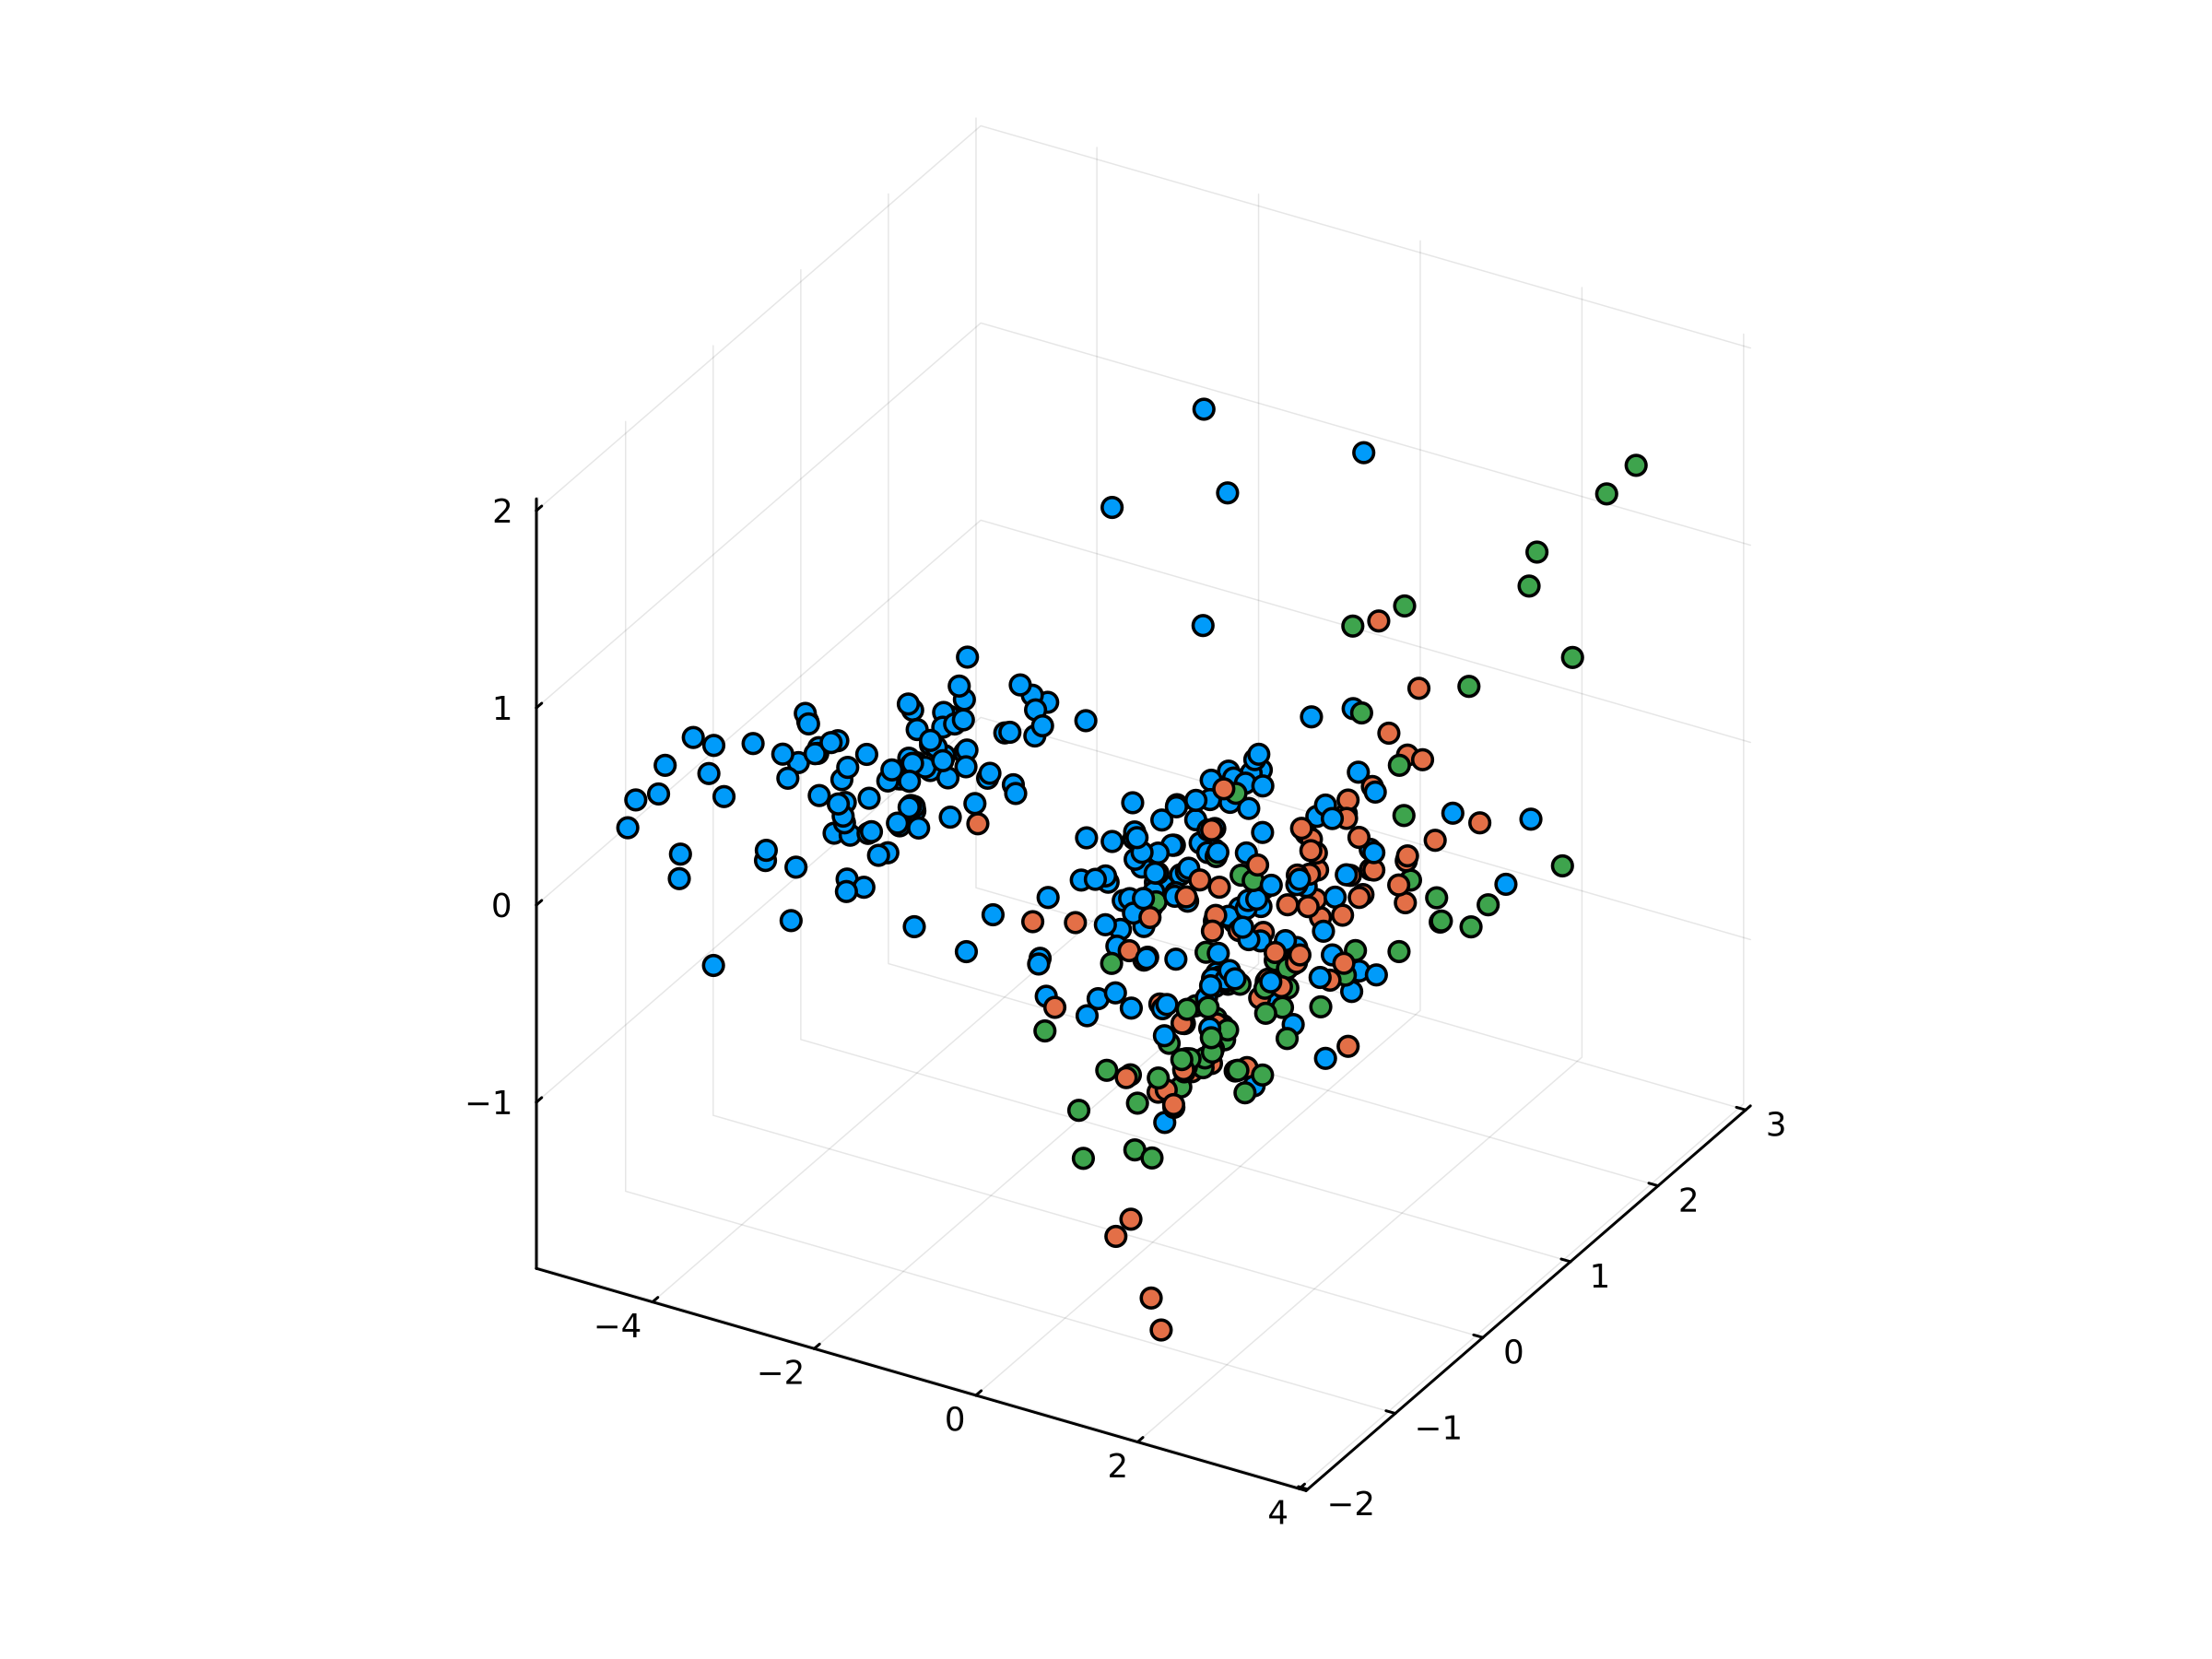

In [15]:
p = fit(PCA,data',maxoutdim=3)
Yte = MultivariateStats.transform(p, data')
scatter3d(Yte[1,:],Yte[2,:],Yte[3,:],color=uniqueids,legend=false)

This is a 3d plot, but eventhough you can set the camera view, you won't be able to move the 3d plot around. Let's use another package for this purpose. We will use `Mackie`.

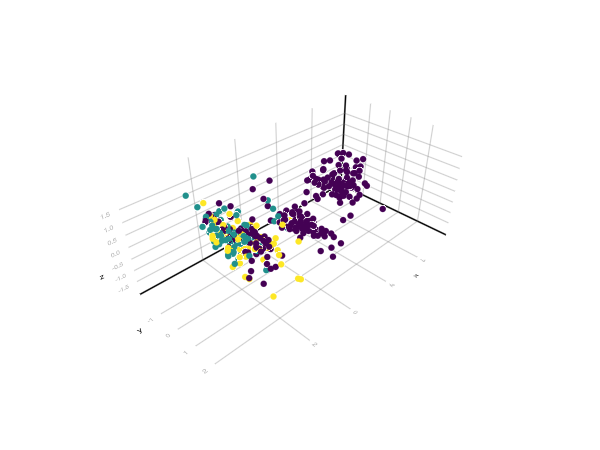

In [16]:
using GLMakie
scene = Makie.scatter(Yte[1,:],Yte[2,:],Yte[3,:],color=uniqueids)

And now, you can call `display(scene)` to create an interactive gui.

In [17]:
display(scene)

GLMakie.Screen(...)

### 2️⃣ t-SNE
The next method we will use for dimensionality reduction is t-SNE. There are multiple ways you can call t-SNE from julia. Check out this notebook: https://github.com/nassarhuda/JuliaTutorials/blob/master/TSNE/TSNE.ipynb. But we will take this opportunity to try out something new... Call a function from the Scikit learn python package. This makes use of the package `ScikitLearn`.

In [18]:
sk_manifold = pyimport("sklearn.manifold")

PyObject <module 'sklearn.manifold' from '/home/sand94/.local/share/mise/installs/python/3.13.3/lib/python3.13/site-packages/sklearn/manifold/__init__.py'>

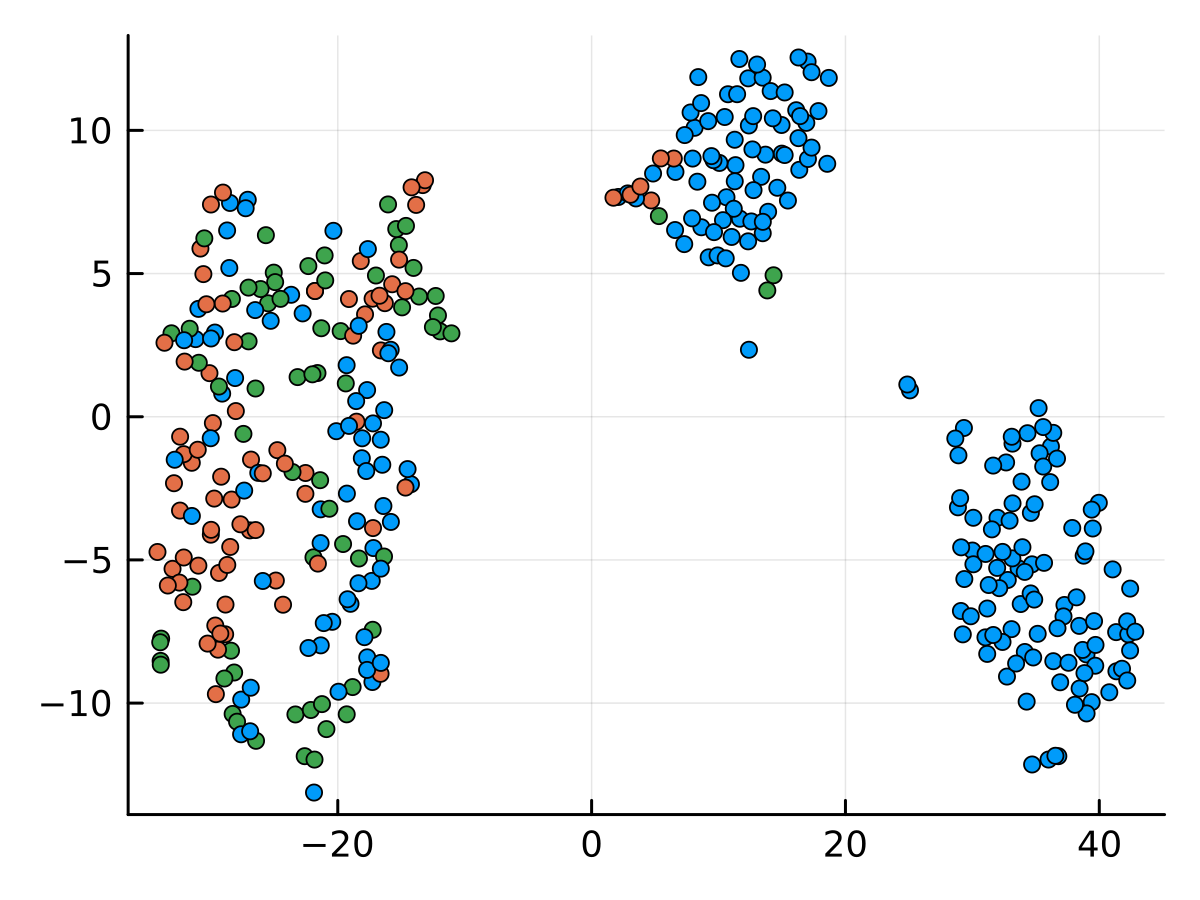

In [19]:
tfn = sk_manifold.TSNE(n_components=2) #,perplexity=20.0,early_exaggeration=50)
Y2 = tfn.fit_transform(data);
Plots.scatter(Y2[:,1],Y2[:,2],color=uniqueids,legend=false,size=(400,300),markersize=3)


This is interesting! The same patterns appears to hold here too. 

### 3️⃣ Next, UMAP
This will be our final dimensionality reduction method and we will use the package `UMAP` for it.

In [20]:
L = cor(data,data,dims=2)
embedding = umap(L, 2)

2×392 Matrix{Float64}:
 9.84422  9.41307  10.0743   9.68105  …  -3.81355  -7.36858  -7.53378
 3.12171  2.68271   2.51121  2.96024      2.88596  -3.48648  -3.09255

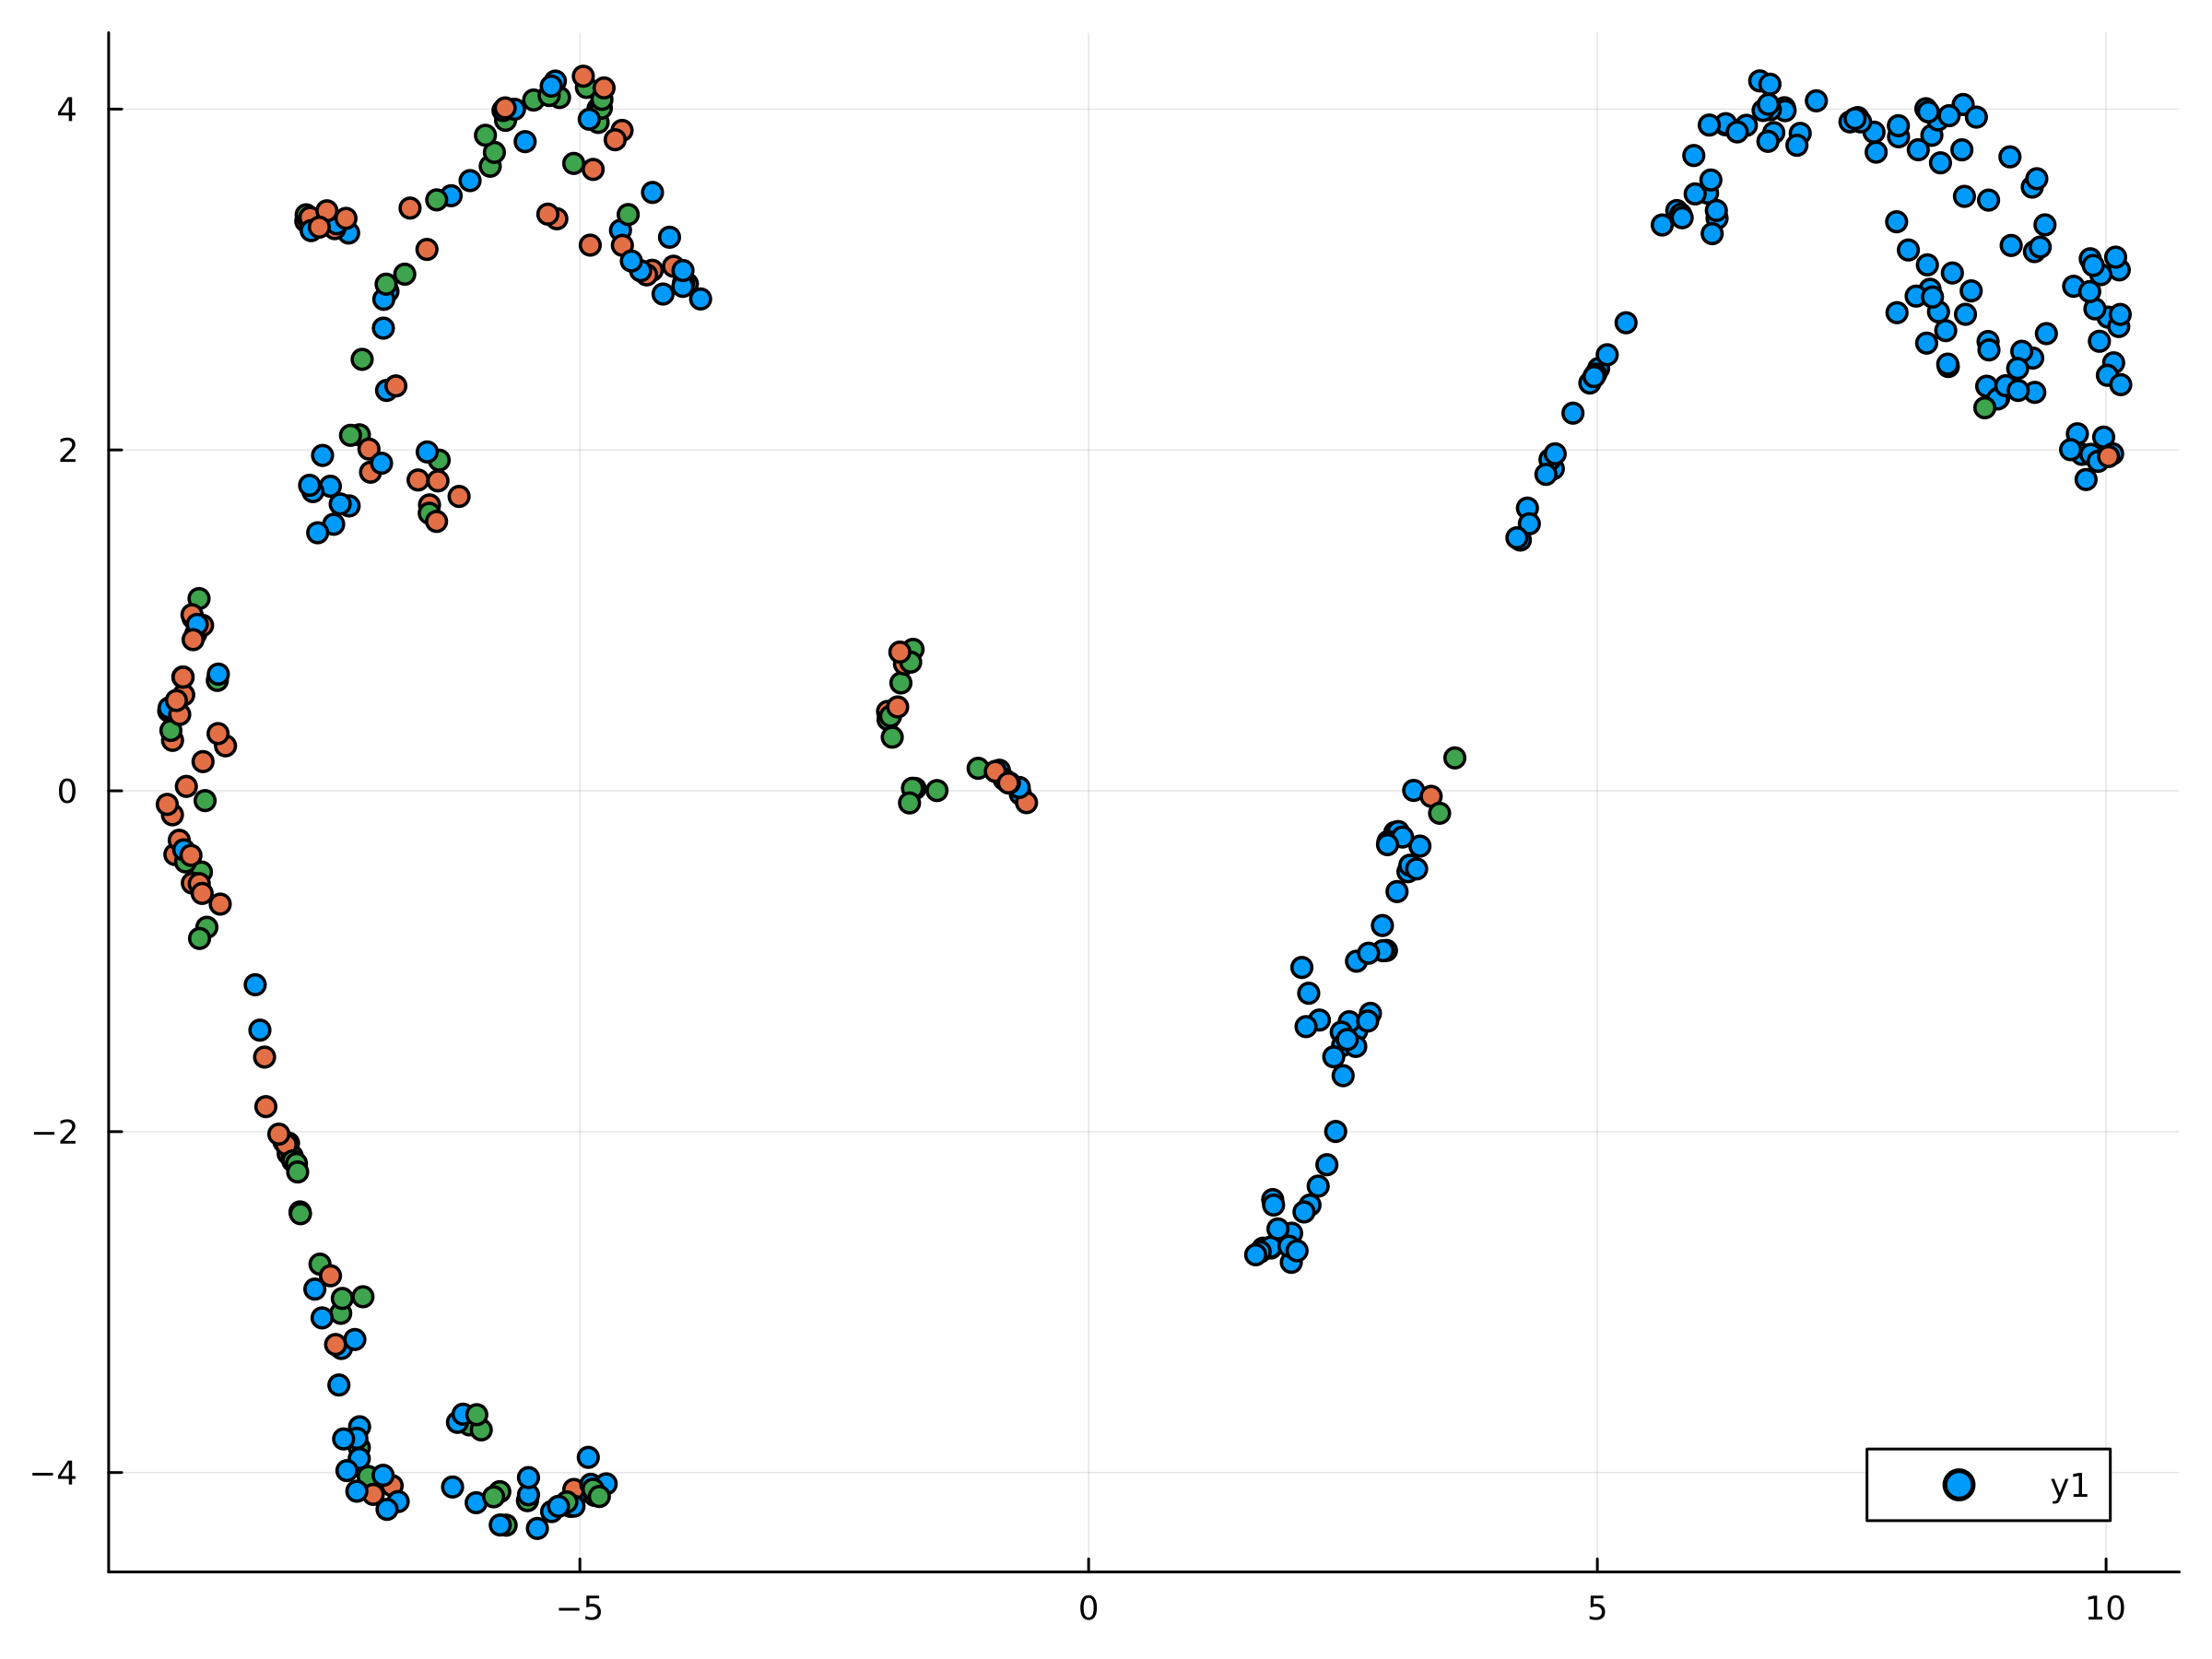

In [21]:
Plots.scatter(embedding[1,:],embedding[2,:],color=uniqueids)

For UMAP, we can create distances between every pair of observations differently, if we choose to. But even with both choices, we will see that UMAP generates a very similar pattern to what we have observed with t-SNE and PCA.

In [22]:
L = pairwise(Euclidean(), data, data,dims=1) 
embedding = umap(-L, 2)

2×392 Matrix{Float64}:
 -7.16683  -8.93937  -7.85466  -7.74722  …   4.2625    6.41182   6.59184
  4.09142   1.39274   3.99729   3.96832     -3.93798  -1.62642  -1.87419

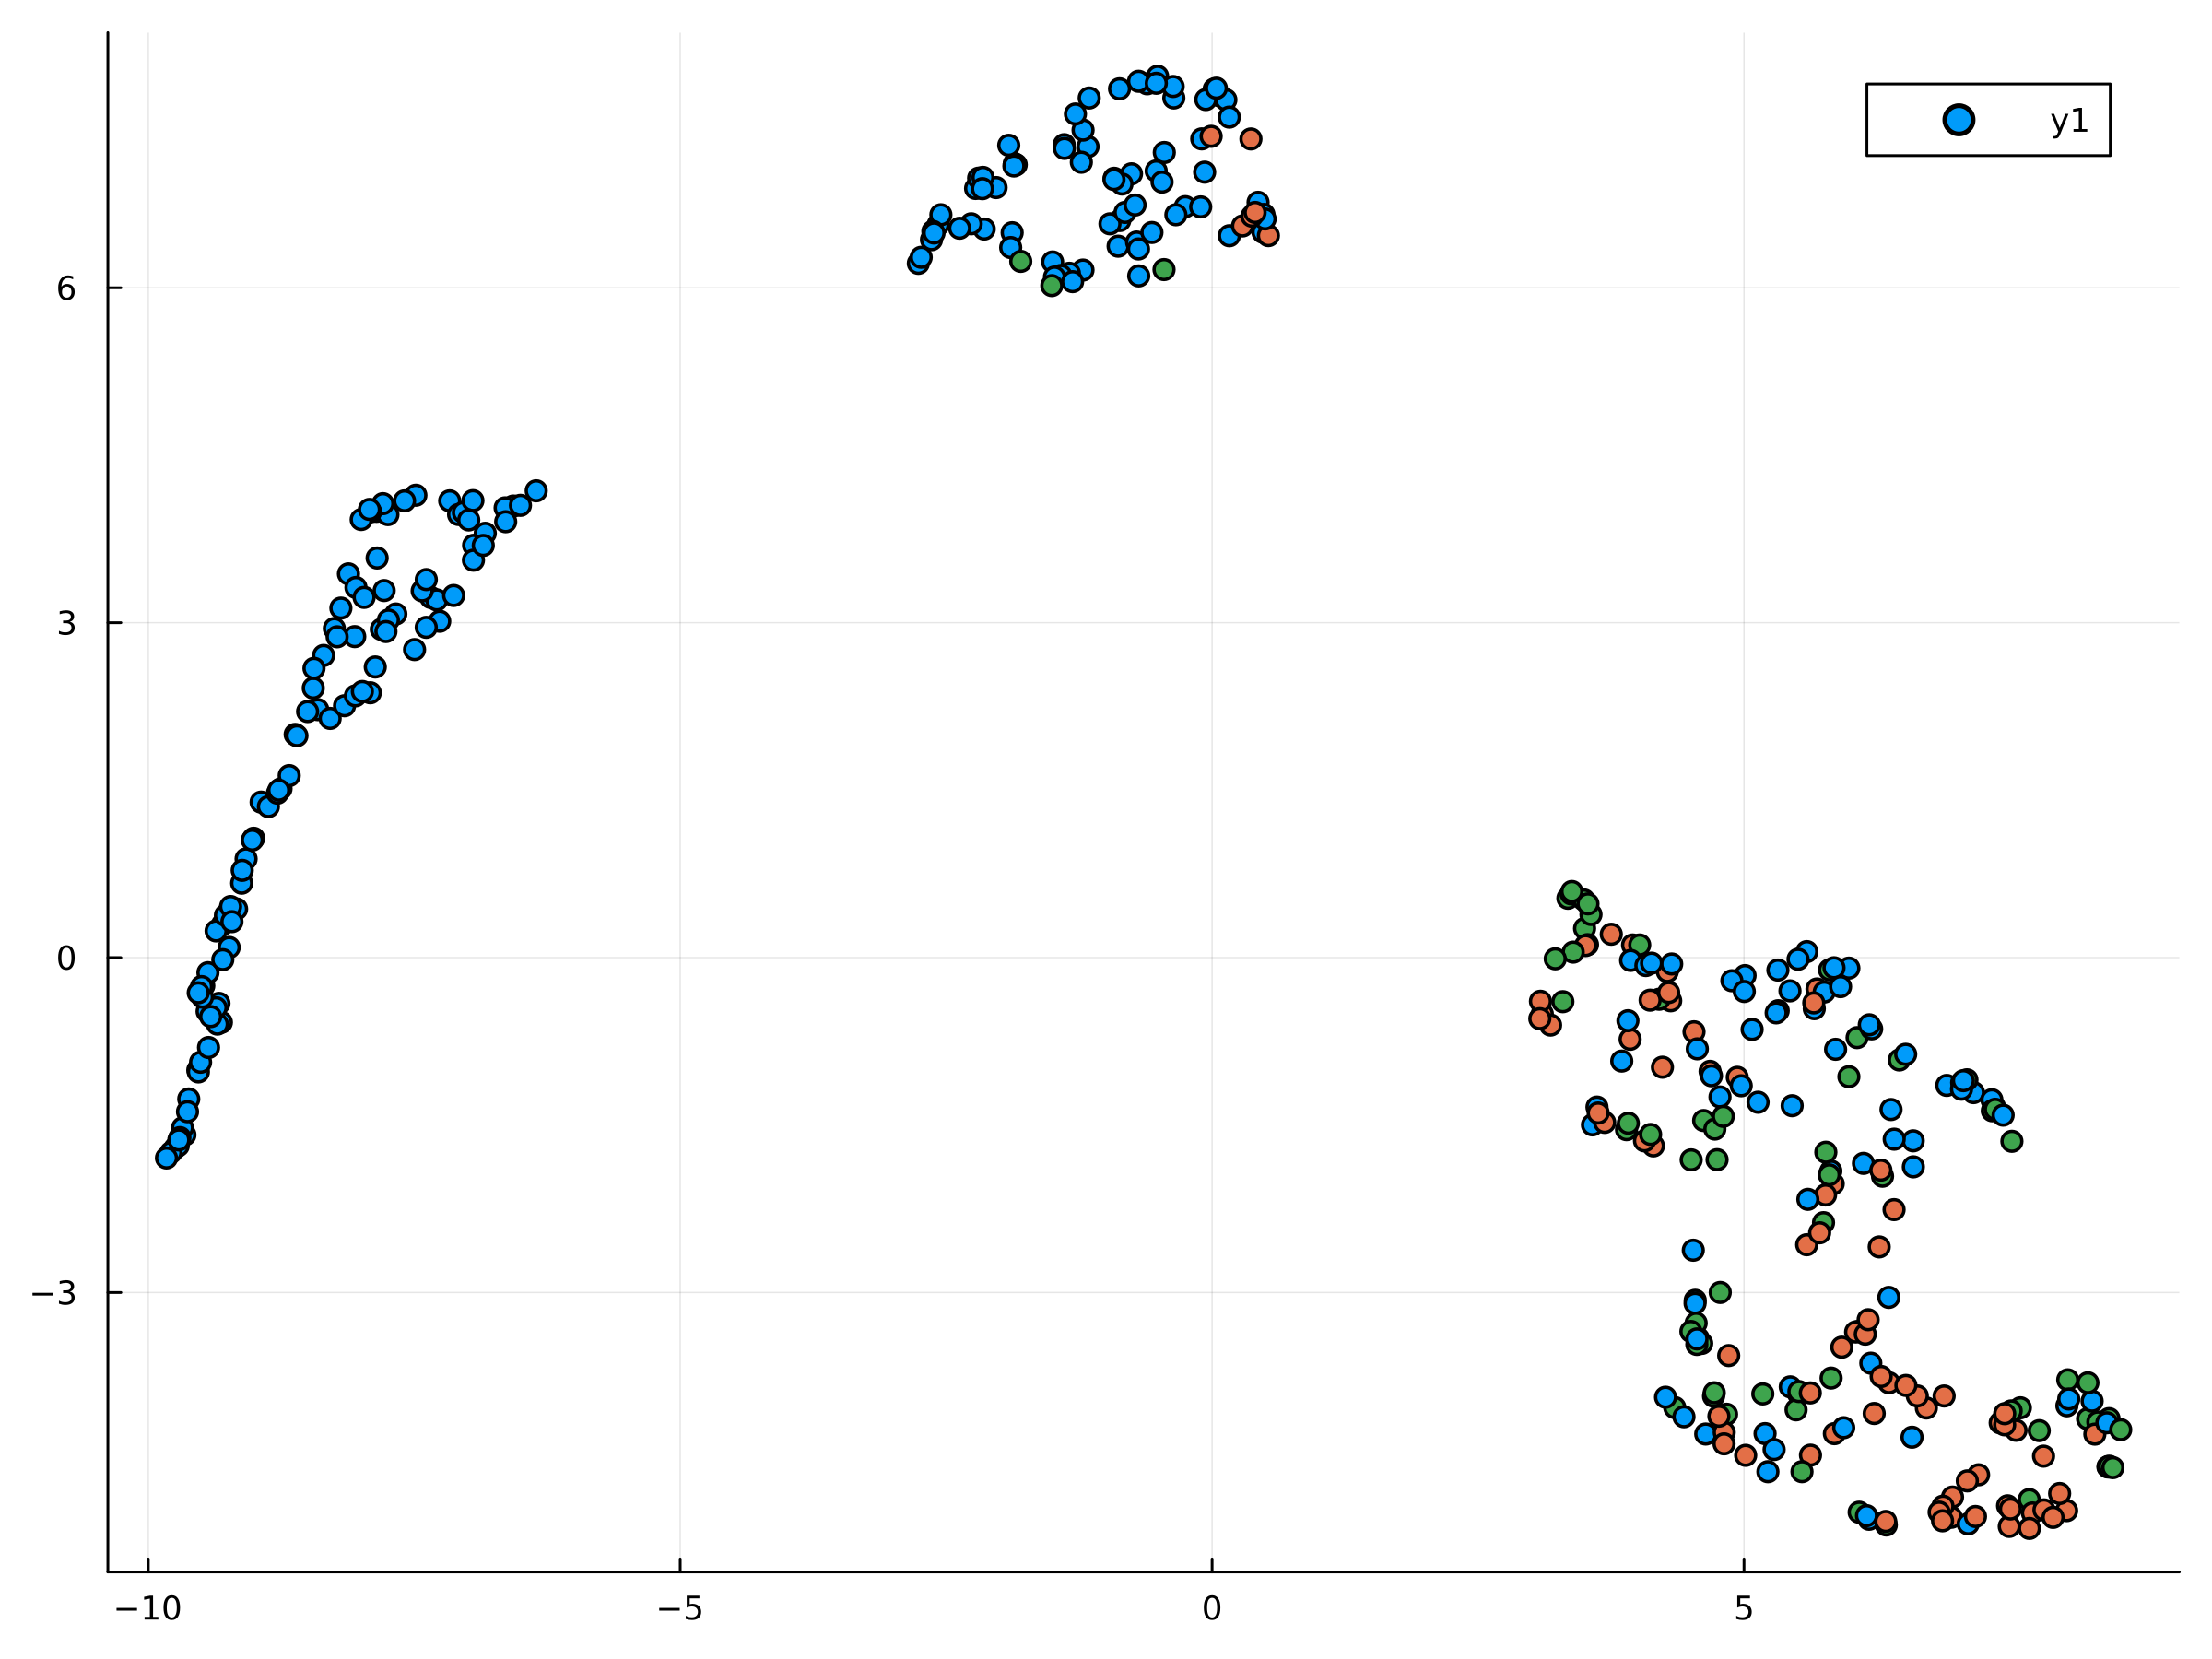

In [23]:
Plots.scatter(embedding[1,:],embedding[2,:],color=uniqueids)

# Finally...
After finishing this notebook, you should be able to:
- apply tsne on your data
- apply umap on your data
- apply pca on your data
- generate a 3d plot